In [1]:
from enum import Enum
from math import cos, pi
import RPi.GPIO as GPIO          
from time import sleep
import picamera2
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import copy
import os
os.environ["LIBCAMERA_LOG_LEVELS"] = "2"

In [2]:
class Cam:
    """
    Singleton class to reuse the same camera instance. 
    You can get only one.
    """
    @classmethod
    def get(cls):
        try:
            return cls.cam
        except:
            cls.cam = picamera2.Picamera2()
            return cls.cam

In [3]:
class Direction(Enum):
    """
    An enum to define directions used by the Car class
    """
    FORWARD = 1
    BACKWARD = -1
    STOP = 0

    def reverse(self):
        if self == Direction.FORWARD:
            return Direction.BACKWARD
        elif self == Direction.BACKWARD:
            return Direction.FORWARD
        return Direction.STOP

In [4]:
class Wheel:
    """
    A single wheel on the car, that is controlled by three GPIO pins on the RPi.
    
    These wheels are designed to automatically update their speed based on the cars
    speed and angle. The angle will slowdown the speed of the wheel according to cosine(angle).
    angle=0 means full speed, angle=90 means stop and angle=-90 means full reverse.
    The intermediate speeds have not ben calibrated and therefore may not scale accordingly.

    Args:
      car: Car
        reference to the car to which this wheel is attached
      enable: int
        GPIO pin that is used for PWM (speed)
      in1, in2: int
        GPIO pins that are used to control direction
      minspeed, maxspeed: int (0-100)
        cab be used to control the minimum and maximum motor speed
    """
    def __init__(self, car, enable, in1, in2, minspeed=50, maxspeed=100):
        self.car = car
        self.enable = enable
        self.in1 = in1
        self.in2 = in2
        GPIO.setup(in1,GPIO.OUT)
        GPIO.setup(in2,GPIO.OUT)
        GPIO.setup(enable,GPIO.OUT)
        try:
            self.pwm = GPIO.PWM(self.enable,1000)
        except:
            print(
'''
An exception occurred setting the PWM pin. 
You can only configure a pin for PWM once, therefore,
if you want to reinstantiate this object, you would
have to restart the notebook and shutdown other notebooks
using the same pin.
''')
            raise
        GPIO.output(self.in1,GPIO.LOW)
        GPIO.output(self.in2,GPIO.LOW)
        self._angle = 0
        self.minspeed=minspeed
        self.maxspeed=maxspeed
        self.speedrange=maxspeed-minspeed
    
    @property
    def angle(self):
        """
        reflects te slowdown for this wheel
        """
        return self._angle

    @angle.setter
    def angle(self, value):
        if value != self.angle:
            self._angle = value
            self.update()

    @property
    def speed(self):
        """
        computes the modified speed of this wheel based on the speed of the car, direction and angle.
        """
        try:
            self._oldspeed = self._speed
        except: pass
        if self.car.direction == Direction.STOP or self.angle == 90:
            #print('wheel stop')
            GPIO.output(self.in1,GPIO.LOW)
            GPIO.output(self.in2,GPIO.LOW)
            self._speed = 0
        elif self.car.direction == Direction.FORWARD and self.angle < 90:
            #print('wheel forward')
            GPIO.output(self.in1,GPIO.LOW)
            GPIO.output(self.in2,GPIO.HIGH)
            self._speed = self.minspeed + (cos(pi * self.angle / 180) * self.speedrange * self.car.speed) // 100
        else:
            #print('wheel backward')
            GPIO.output(self.in1,GPIO.HIGH)
            GPIO.output(self.in2,GPIO.LOW)
            self._speed = self.minspeed + (cos(pi * (180 - self.angle) / 180) * self.speedrange * self.car.speed) // 100
        return self._speed        

    def update(self):
        """
        updates the wheel speed
        """
        speed = self.speed
        try:
            if speed != self._old_speed:
                if speed == 0:
                     self.pwm.stop()
                elif self._old_speed == 0:
                    self.pwm.start(speed)
                else:
                    self.pwm.ChangeDutyCycle(self.speed)
        except:
            self.pwm.start(speed)
        self._old_speed = speed

In [5]:
class Car:
    """
    A car that is controlled by this RPi, through direction, speed and angle properties.

    The car has two wheel that will modify their speed based on direction, speed and angle.
    """
    @classmethod
    def get(cls, camera_is_upside_down=True):
        """
        To allow grabbing several objects of a car, without complaints
        about the PWM pins being in use.
        """
        try:
            r = copy.copy(cls._instance)
            r.camera_is_upside_down = camera_is_upside_down
            return r
        except:
            GPIO.setwarnings(False)
            GPIO.setmode(GPIO.BCM)
            self = cls()
            self._speed = 100
            self._direction = Direction.STOP
            self._angle = 0
            self.right = Wheel(self, 25, 23, 24, minspeed=40)
            self.left = Wheel(self, 21, 20, 16, minspeed=40)
            self.camera_is_upside_down = camera_is_upside_down
            cls._instance = self
            return self
    
    @property
    def cam(self):
        try:
            return self._cam
        except:
            self._cam = Cam.get()
            return self._cam

    def new_image(self):
        """
        Take a new image
        """
        if not self.cam.started:
            self.cam.start()
        self._img = self.cam.capture_array()[:,:,:3]
        if self.camera_is_upside_down:
            self._img = self._img[::-1,::-1]
        return self._img

    def image(self):
        """
        Return the current image
        """
        try:
            return self._img
        except:
            return self.new_image()

    def save_image(self, folder, filename):
        """
        Save an image to a file

        Args:
            folder: Path
            filename: str
        """
        img = Image.fromarray(self.image())
        img.save( folder / filename ) 
    
    def show_image(self):
        """
        Shows an image in a notebook cell
        """
        plt.imshow(self.image())

    @property
    def direction(self):
        return self._direction

    @direction.setter
    def direction(self, value):
        if self._direction != value:
            self._direction = value
            self.left.update()
            self.right.update()
    
    @property
    def angle(self):
        return self._angle

    @angle.setter
    def angle(self, value):
        """
        controls the direction of the car by slowing down one of the wheels (-180 +180)
        angle = 0 is forward (although it will never go straight on 2 DC motors
        angle = 90 will stop the right wheel (turn around the right wheel)
        angle = 180 will reverse the right wheel (turn in place)
        angle = -90 will stop the left wheel (turn around the left wheel)
        angle = -180 will reverse the left wheel (turn in place)
        """
        if self.angle != value:
            self._angle = value
            if value > 0:
                self.right.angle = value
                self.left.angle = 0
            else:
                self.left.angle = -value
                self.right.angle = 0
    
    @property
    def speed(self):
        return self._speed

    @speed.setter
    def speed(self, value):
        """
        controls the speed of the car, value 0-100
        """
        if self._speed != value:
            self._speed = value
            self.left.update()
            self.right.update()
        
    def forward(self):
        """
        Start the car moving forward, if the speed is big enough
        """
        self.direction = Direction.FORWARD

    def backward(self):
        """
        Start the car moving backwards.
        """
        self.direction = Direction.BACKWARD
        
    def stop(self):
        """
        Stop the car
        """
        self.direction = Direction.STOP

In [6]:
def demo_move():
    """
    Call this to get a demo of the car moving, make sure it has space.
    """
    c = Car.get()
    try:    # the try finally is here to make sure that if anything 
             # goes wrong, the car will stop
        c.speed = 100
        c.forward()
        sleep(1)
        c.angle(45)
        sleep(1)
        c.angle(90)
        sleep(1)
        c.angle(0)
        sleep(1)
    finally:
        c.stop()

In [7]:
def demo_image():
    """
    Call this to grab and show an image from the camera
    """
    c = Car.get()
    c.show_image()

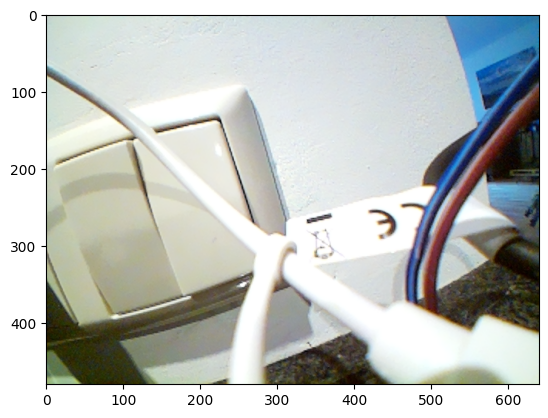

In [8]:
demo_image()